## Setup

In [114]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [116]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [117]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [118]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [119]:
%%R
library(tidycensus)
library(dplyr)

# Load all ACS5 variables
acs5_vars <- load_variables(2021, "acs5", cache = FALSE)

# Search for any disability-related variables
disability_vars <- acs5_vars %>% filter(grepl("disability", label, ignore.case = TRUE))

# Print the first few results
print(disability_vars)


# A tibble: 353 × 4
   name       label                                            concept geography
   <chr>      <chr>                                            <chr>   <chr>    
 1 B10052_002 Estimate!!Total:!!With any disability:           DISABI… tract    
 2 B10052_003 Estimate!!Total:!!With any disability:!!Grandpa… DISABI… tract    
 3 B10052_004 Estimate!!Total:!!With any disability:!!Grandpa… DISABI… tract    
 4 B10052_005 Estimate!!Total:!!With any disability:!!Grandpa… DISABI… tract    
 5 B10052_006 Estimate!!Total:!!With any disability:!!Grandpa… DISABI… tract    
 6 B10052_007 Estimate!!Total:!!No disability:                 DISABI… tract    
 7 B10052_008 Estimate!!Total:!!No disability:!!Grandparent r… DISABI… tract    
 8 B10052_009 Estimate!!Total:!!No disability:!!Grandparent r… DISABI… tract    
 9 B10052_010 Estimate!!Total:!!No disability:!!Grandparent r… DISABI… tract    
10 B10052_011 Estimate!!Total:!!No disability:!!Grandparent n… DISABI… tract    
# ℹ 343 

In [120]:
%%R
library(tidycensus)
library(dplyr)

# Load ACS5 variable names again without cache
acs5_vars <- load_variables(2021, "acs5", cache = FALSE)

# Check if B18120 exists
b18120_vars <- acs5_vars %>% filter(grepl("^B18120", name))

# Print results
print(b18120_vars)

# A tibble: 0 × 4
# ℹ 4 variables: name <chr>, label <chr>, concept <chr>, geography <chr>


In [133]:
%%R 

# the variable B01003_001 was selectd from the census table 
# for population, which we found in censusreporter here:
# https://censusreporter.org/tables/B01003/


# Here are the various geographies you can use with tidycensus
# https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus

# Get variable from ACS
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B01003_001",
                        med_inc="B19013_001",
                        employment_disability="B10052_003"
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T)

nyc_census_data

Simple feature collection with 6981 features and 5 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                       NAME              variable
1  36081014700  Census Tract 147, Queens County, New York            population
2  36081014700  Census Tract 147, Queens County, New York employment_disability
3  36081014700  Census Tract 147, Queens County, New York               med_inc
4  36047058400   Census Tract 584, Kings County, New York            population
5  36047058400   Census Tract 584, Kings County, New York employment_disability
6  36047058400   Census Tract 584, Kings County, New York               med_inc
7  36061006900 Census Tract 69, New York County, New York            population
8  36061006900 Census Tract 69, New York County, New York employment_disability
9  36061006900 Census Tract 69, Ne

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [134]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  ) # pivot from wide to long

nyc_census_data

Simple feature collection with 2327 features and 8 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 9
   GEOID       NAME                                 geometry population_estimate
   <chr>       <chr>                      <MULTIPOLYGON [°]>               <dbl>
 1 36081014700 Census Tract 147, … (((-73.9137 40.76548, -7…                2863
 2 36047058400 Census Tract 584, … (((-73.96103 40.59616, -…                3655
 3 36061006900 Census Tract 69, N… (((-74.02064 40.73039, -…                2450
 4 36047073000 Census Tract 730, … (((-73.93345 40.6257, -7…                2676
 5 36047100400 Census Tract 1004,… (((-73.90735 40.63083, -…                3004
 6 36047055700 Census Tract 557, … (((-73.96279 40.72256, -…                1834
 7 36005022101 Census Tract 221.0… (((-73.92012 40.83759, -…                4030
 8 36081047000 Census Tr

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [135]:
%%R 

# Extract borough name from NAME by splitting strings like "Census Tract 147, Queens County, New York" 
# on commas and extracting the second to last element

nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim(),
        units_per_person = employment_disability_estimate / population_estimate
        
    ) 

nyc_census_data

Simple feature collection with 2327 features and 10 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 11
   GEOID       NAME                                 geometry population_estimate
 * <chr>       <chr>                      <MULTIPOLYGON [°]>               <dbl>
 1 36081014700 Census Tract 147, … (((-73.9137 40.76548, -7…                2863
 2 36047058400 Census Tract 584, … (((-73.96103 40.59616, -…                3655
 3 36061006900 Census Tract 69, N… (((-74.02064 40.73039, -…                2450
 4 36047073000 Census Tract 730, … (((-73.93345 40.6257, -7…                2676
 5 36047100400 Census Tract 1004,… (((-73.90735 40.63083, -…                3004
 6 36047055700 Census Tract 557, … (((-73.96279 40.72256, -…                1834
 7 36005022101 Census Tract 221.0… (((-73.92012 40.83759, -…                4030
 8 36081047000 Census 

### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 88 rows containing non-finite outside the scale range (`stat_bin()`). 



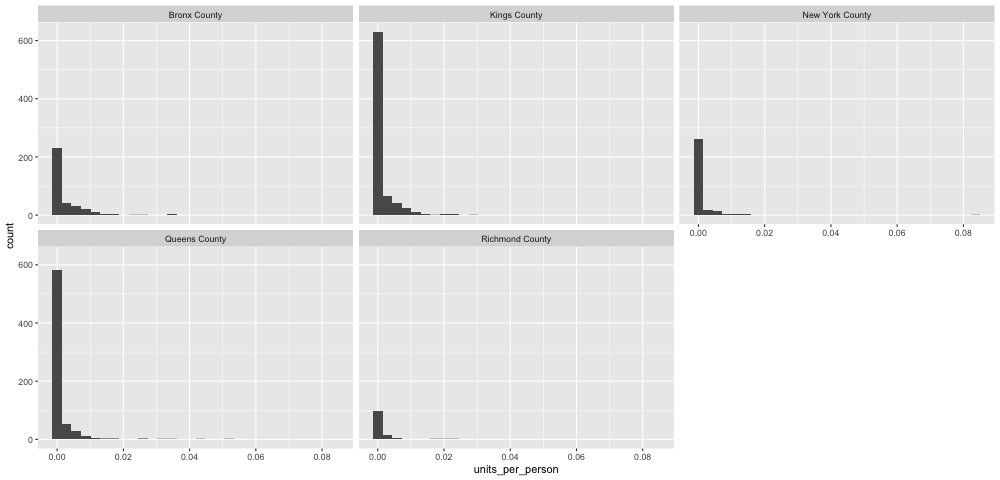

In [136]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=unit_per_person) +
    geom_histogram() + 
    facet_wrap(~borough) 

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 88 rows containing missing values or values outside the scale range
(`stat_bindot()`). 



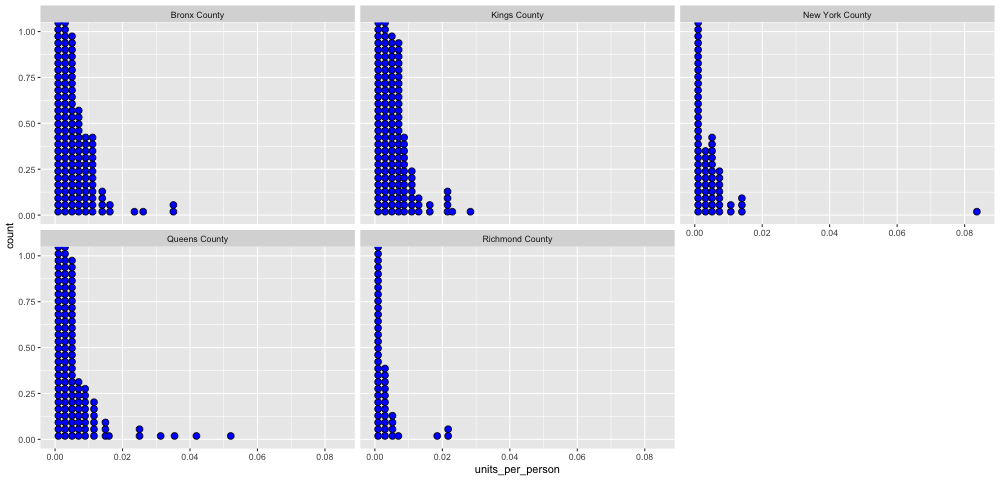

In [137]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=units_per_person) +
    geom_dotplot(binwidth = 0.002, dotsize = 1, fill = "blue") + 
    facet_wrap(~borough) 

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 88 rows containing non-finite outside the scale range
(`stat_boxplot()`). 



In addition: Warning message:
In geom_boxplot(binwidth = 0.005, dotsize = 1, fill = "blue") :
  Ignoring unknown parameters: `binwidth` and `dotsize`


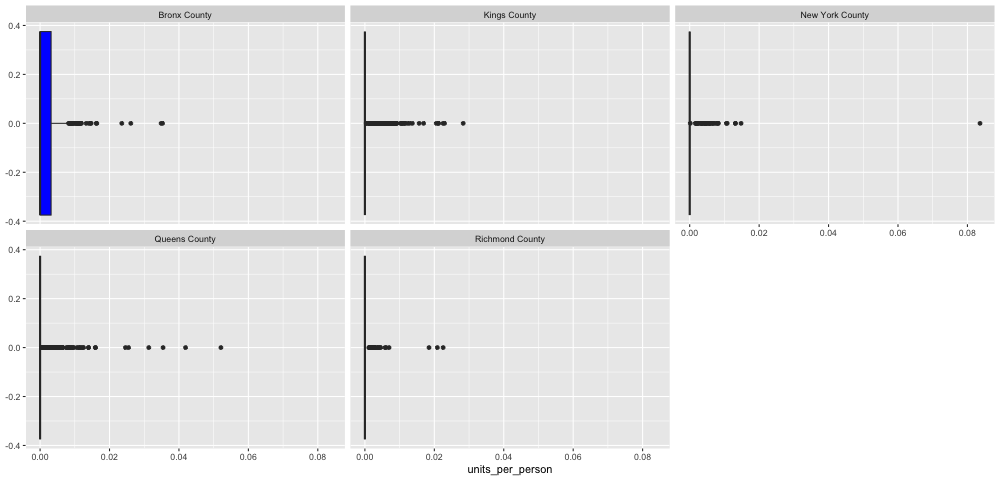

In [152]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=units_per_person) +
    geom_boxplot(binwidth = 0.005, dotsize = 1, fill = "blue") + 
    facet_wrap(~borough) 

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

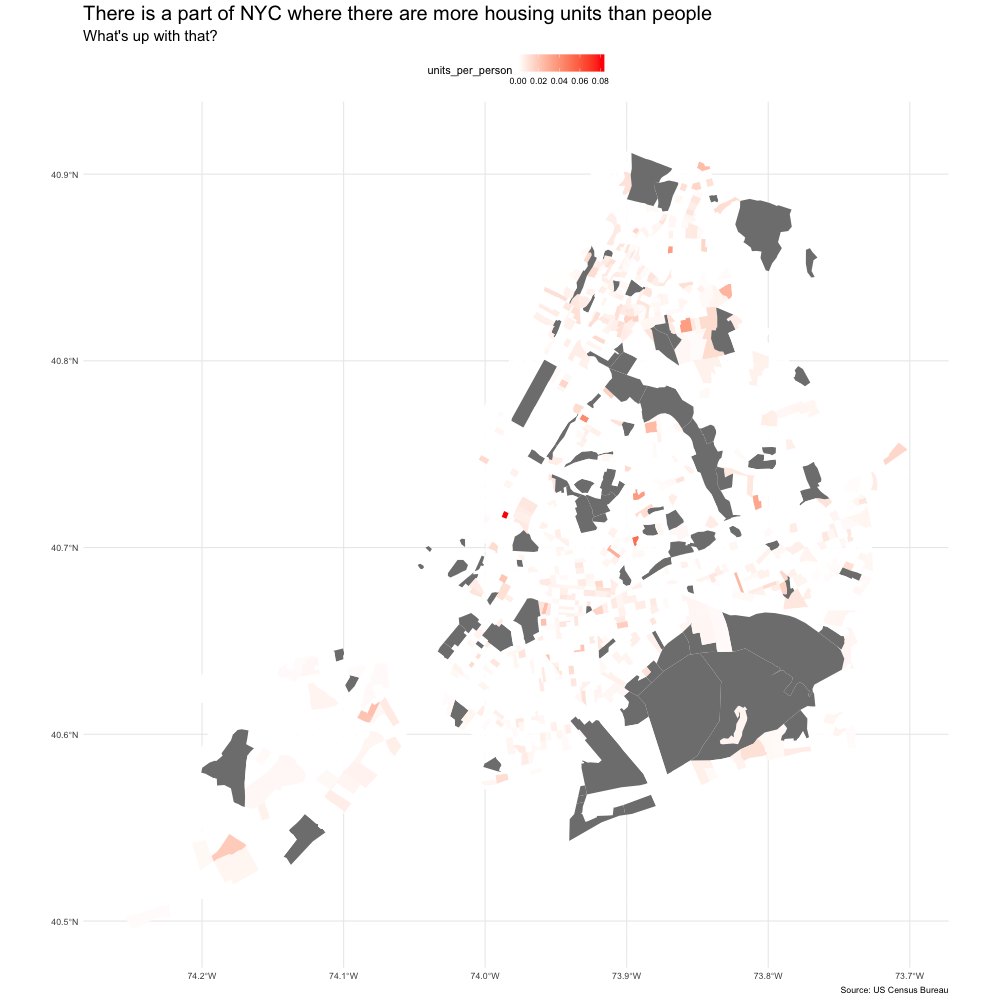

In [139]:
%%R -w 1000 -h 1000

# your code here. refer to example notebooks for help
nyc_census_data %>%
  ggplot(aes(fill = units_per_person)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  theme_minimal() +
  labs(
    title = "There is a part of NYC where there are more housing units than people",
    subtitle = "What's up with that?",
    caption = "Source: US Census Bureau"
  ) +
  theme(
    #make title and subitle bigger
    plot.title = element_text(size = 20),
    plot.subtitle = element_text(size = 15),
    # move legend to top
    legend.position = "top"
  )

In [148]:
%%R
result <- nyc_census_data %>%
  filter(borough == "New York County") %>%  # Fixed quotes
  arrange(desc(units_per_person)) %>%  # Sort in descending order
  slice_head(n = 10)  # Get the top 5 rows

In [147]:
%%R
print(result$GEOID)

[1] "36061001402" "36061016400" "36061027700" "36061009300" "36061023600"
